# Import Libraries

In [20]:
try:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from PIL import Image as img
    from dotenv import load_dotenv
    import os
    import neptune
    import cv2
    from tqdm import tqdm as tq
    print("Successfully Imported Libararies")

except ImportError as ie:
    print("Failed to import modules")
    print("Details: {}".format(ie))

Successfully Imported Libararies


# Global Variable Definition

In [3]:
# load environment variables from.env file
load_dotenv()

True

## Neptune AI Config

In [4]:
#Initialize neptune project run
neptune_project=os.getenv('NEPTUNE_PROJECT_ID')
neptune_api_token=os.getenv('NEPTUNE_API_TOKEN')

run = neptune.init_run(
    project=neptune_project,
    api_token=neptune_api_token,
) 

/tmp/ipykernel_261059/1914578359.py:5: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(


https://app.neptune.ai/blaise-papa/diagnosft-ai/e/DIAG-3


## Data Ingestion

In [5]:
#define path to scans
scan_path=os.getenv('SCAN_PATH')
metadata_path=os.getenv('METADATA_PATH')

try:
    #define metadata file path
    metadata=pd.read_csv(metadata_path)
    print("Loaded metadata file")
except FileNotFoundError:
    print("metadata.csv not found")

Loaded metadata file


# Initial Analyis

In [6]:
metadata

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal
...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...


# Feature Engineering

## Setting up binary classes

In [7]:
#create a new column called labels that returns normal for all normal columns and abnromal for anything else
metadata['labels']=metadata.apply(lambda row: 'normal' if row['findings'] == 'normal' else 'abnormal',axis=1)

In [8]:
metadata

,study_id,sex,age,findings,labels
0,CHNCXR_0001_0.png,Male,45,normal,normal
1,CHNCXR_0002_0.png,Male,63,normal,normal
2,CHNCXR_0003_0.png,Female,48,normal,normal
3,CHNCXR_0004_0.png,Male,58,normal,normal
4,CHNCXR_0005_0.png,Male,28,normal,normal
...,...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax,abnormal
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field,abnormal
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...,abnormal
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...,abnormal


## Adding path names

In [9]:
## addding full filepath to new column for easier reference 
metadata['path']=scan_path + metadata['study_id']

In [10]:
metadata

,study_id,sex,age,findings,labels,path
0,CHNCXR_0001_0.png,Male,45,normal,normal,../data/unzipped_images/shenzhen_images/images...
1,CHNCXR_0002_0.png,Male,63,normal,normal,../data/unzipped_images/shenzhen_images/images...
2,CHNCXR_0003_0.png,Female,48,normal,normal,../data/unzipped_images/shenzhen_images/images...
3,CHNCXR_0004_0.png,Male,58,normal,normal,../data/unzipped_images/shenzhen_images/images...
4,CHNCXR_0005_0.png,Male,28,normal,normal,../data/unzipped_images/shenzhen_images/images...
...,...,...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax,abnormal,../data/unzipped_images/shenzhen_images/images...
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field,abnormal,../data/unzipped_images/shenzhen_images/images...
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...,abnormal,../data/unzipped_images/shenzhen_images/images...
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...,abnormal,../data/unzipped_images/shenzhen_images/images...


## Display Images

In [11]:
first_five=metadata[metadata['labels'] == 'normal'][0:5]['path']
first_five_abn=metadata[metadata['labels'] == 'abnormal'][0:5]['path']

### Healthy Images

<Figure size 1000x1000 with 0 Axes>

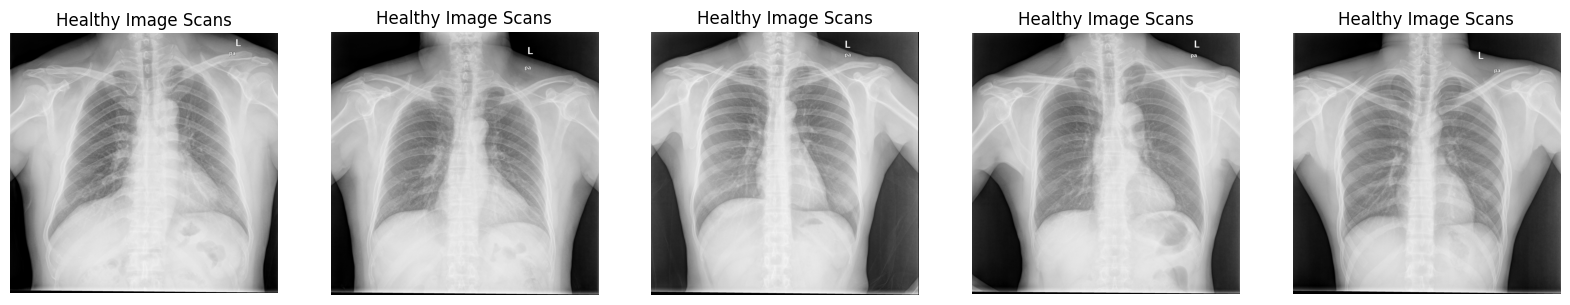

In [12]:
#use matplotlib to plot the images
plt.figure(figsize=(10,10))
fig,axes=plt.subplots(1,5,figsize=(20,20))

images=[img.open(image) for image in first_five]

#display images in separate subplots
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title("Healthy Image Scans")
    ax.axis("off")

### TB Cases

<Figure size 1000x1000 with 0 Axes>

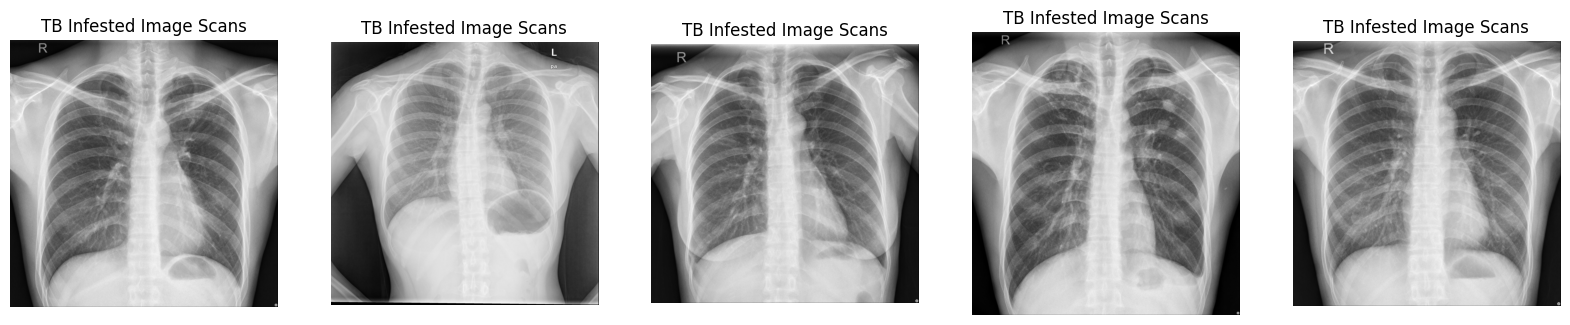

In [13]:
#plotting unhealthy scans
#use matplotlib to plot the images
plt.figure(figsize=(10,10))
fig,axes=plt.subplots(1,5,figsize=(20,20))

images=[img.open(image) for image in first_five_abn]

#display images in separate subplots
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title("TB Infested Image Scans")
    ax.axis("off")

## Image Preprocessing

In [21]:
img=cv2.imread(first_five[0])

In [22]:
img.shape

(2919, 3000, 3)

In [18]:
image_data=[]

img=cv2.imread(first_five[0])
image=cv2.resize(img, (100, 100))

# Convert from BGR to RGB (OpenCV loads images in BGR format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Convert the image to a NumPy array and normalize pixel values to [0, 1]
image_array = np.array(image) / 255.0
        
image_data.append(image_array)




In [28]:
#create function load images as arrays into numpy arrays
def load_images_to_array(path: str, image_size=(2500,2500)) -> np.ndarray:
    images = []
    index= []

    for i,scan in enumerate(tq(path)):
        try:
            # Use OpenCV to read and preprocess the image
            image=cv2.imread(scan)

            # Resize the image to the desired size
            image=cv2.resize(image,image_size)

            # Convert from BGR to RGB (OpenCV loads images in BGR format)
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

            # Convert the image to a NumPy array and normalize pixel values to [0, 1]
            image_array=np.array(image) /255.0
            images.append(image_array)
            index.append(i)
        except Exception as e:
            print(e)
            continue
    return np.array(images),np.array(index)


In [29]:
scn_array,scn_position=load_images_to_array(metadata['path'])

 88%|████████▊ | 581/662 [01:06<00:17,  4.60it/s]

# BaseLine Model